# Задание 2

In [21]:
import warnings
warnings.filterwarnings("ignore")

Подключаем необходимые библиотеки

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec
import pickle
import mlflow
from mlflow.models import infer_signature

Считываем данные и формируем dataset. Выводим для наглядности немного данных.

In [27]:
dataset = pd.read_csv('dataset.csv')
dataset.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


### Задание 1
Визуализируйте с помощью boxplot загруженные данные, опишите ваши мысли по данным.

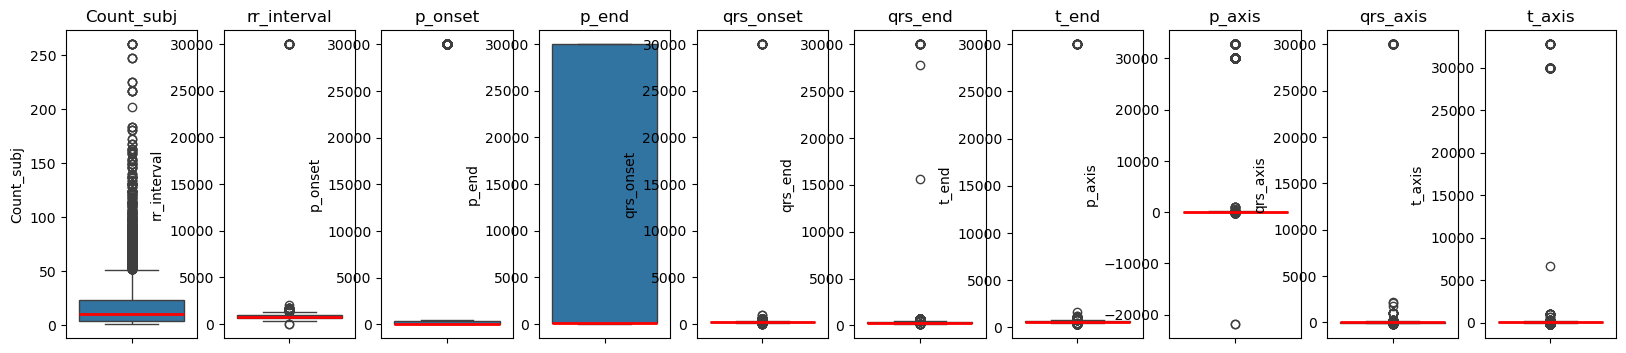

In [30]:
# Визуализация распределения числовых признаков
numerical_cols = ['Count_subj', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
n = len(numerical_cols)
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    index = dataset.columns.get_loc(numerical_cols[i]) # Относительный индекс
    plt.sca(ax[i])
    col = dataset.columns[index]
    ax[i].set_title(col)
    sns.boxplot(y=dataset.iloc[:,index], data=dataset, medianprops={'color': 'r', 'linewidth': 2})

Описание данных:

- Healthy_Status:
Бинарный признак (0 или 1), где 0 может означать наличие патологии, а 1 — норму. Распределение можно проверить с помощью value_counts().
- Числовые признаки:
rr_interval: Интервал RR (время между сердечными сокращениями). Выбросы могут указывать на аритмии.
p_axis, qrs_axis, t_axis: Электрические оси сердца. Аномальные значения могут свидетельствовать о патологиях (например, отклонение оси влево/вправо).
- Категориальные признаки:
report_0, report_1, и т.д.: Текстовые описания диагнозов. Можно выделить частые термины (например, "Sinus rhythm", "Abnormal ECG").
- Выбросы:
На boxplot для rr_interval видны значительные выбросы, что может соответствовать брадикардии (слишком медленный ритм) или тахикардии (слишком быстрый ритм).
- Фильтрация и пропуски:
В данных есть пропуски (например, filtering содержит "<not specified>"). Это может повлиять на анализ.
Примеры аномалий:

Значения 29999 в столбцах p_onset, p_end и др. — вероятно, маркеры ошибок или отсутствия данных.
В Healthy_Status может быть дисбаланс классов (например, больше пациентов с патологиями).


### Задание 2
Проанализируйте данные и  проведите их предобработку (очистку, обогащение).

In [33]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = dataset[(dataset[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Исправляем имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.037137,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.037137,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,-0.009222,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.000424,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.000424,952,40,146,198,282,598,24,80,20,1


### Задание 3
Сформируйте очищенный датасет, состоящий из числовых параметров ЭКГ и классификационного признака Healthy_Status, заново построить boxplot и сравните результаты с первоначальным.

In [37]:
# make new dataset from old columns
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,0.037137,659,128,170,258,518,81,77,79,0
1,0.037137,722,124,162,246,504,77,75,70,0
2,-0.009222,600,130,162,244,474,79,72,77,1
3,0.000424,659,146,180,254,538,79,66,69,1
6,0.000424,952,146,198,282,598,24,80,20,1


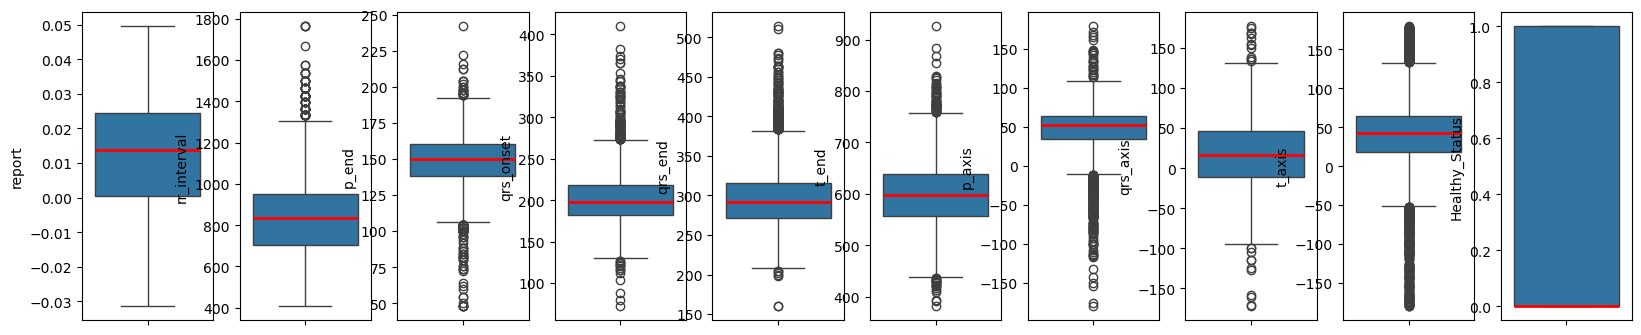

In [40]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

### Задание 4
Проведите оценку взаимосвязи данных датасета с помощью функции heatmap.


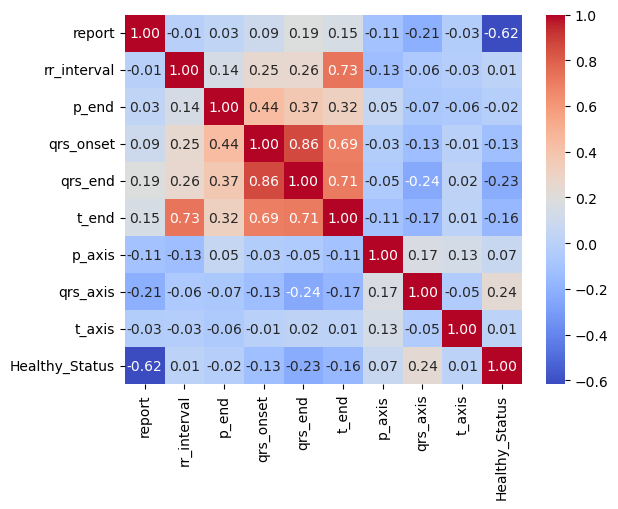

In [43]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

### Задание 5
На основе таргета (целевого признака) Healthy_Status построить корреляционную матрицу с помощью pairplot.


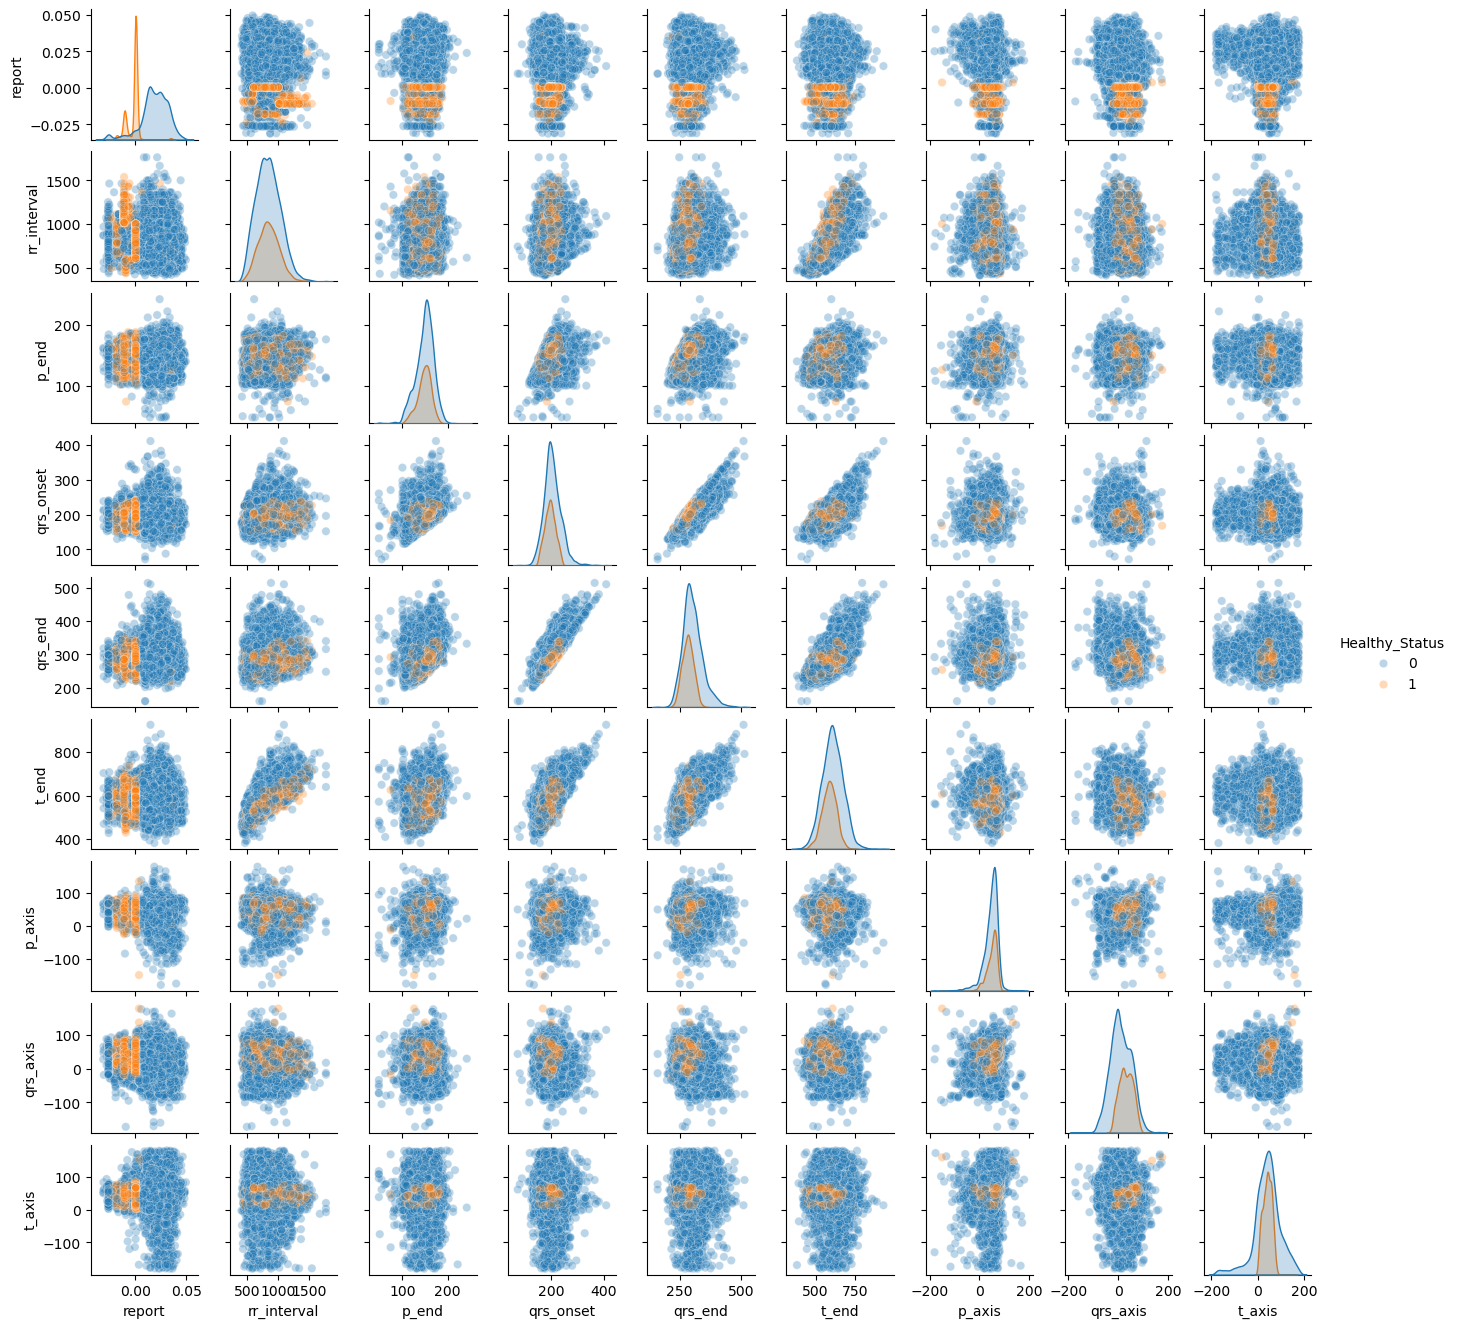

In [46]:
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

### Задание 6
Провести разведочный анализ данных с помощью метода PCA и с помощью TSNE.


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [49]:
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [50]:
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(7046, 10) (7046, 2)


In [51]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.34539303 0.14174874]
0.4871417709304827


In [52]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.71% explained variance
3 components at 61.45% explained variance
4 components at 72.97% explained variance
5 components at 82.04% explained variance
6 components at 90.16% explained variance


Text(0, 0.5, 'Second Principal Component')

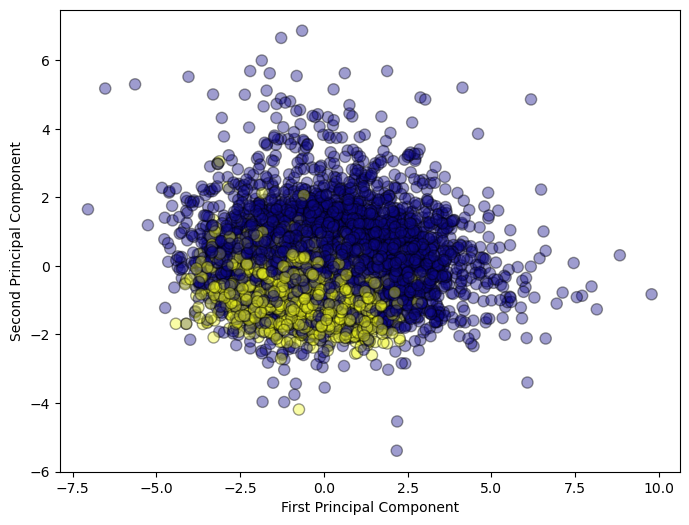

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

### Задание 7
Сделать вывод о структуре признаков данных

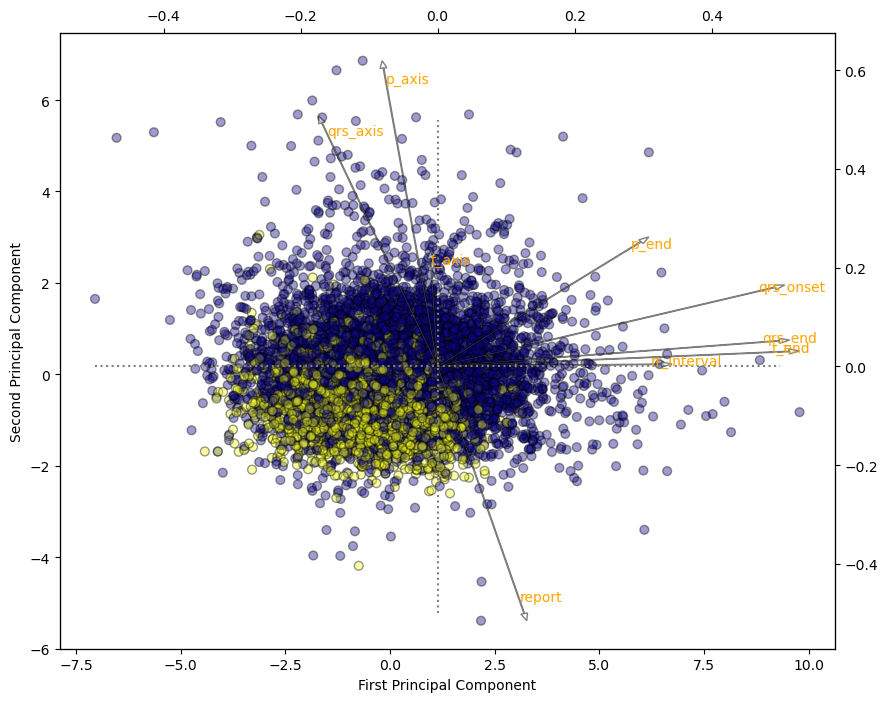

In [55]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(10,8))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

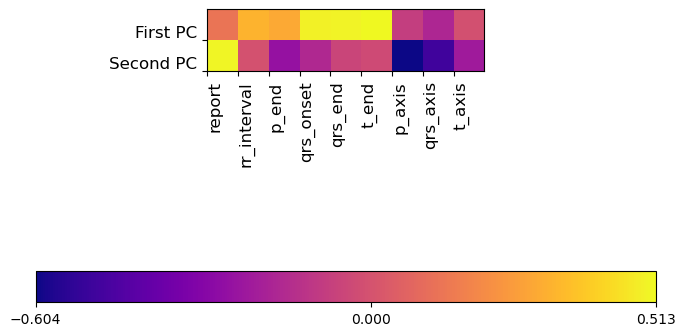

In [56]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

Text(0, 0.5, 'Second Principal Component')

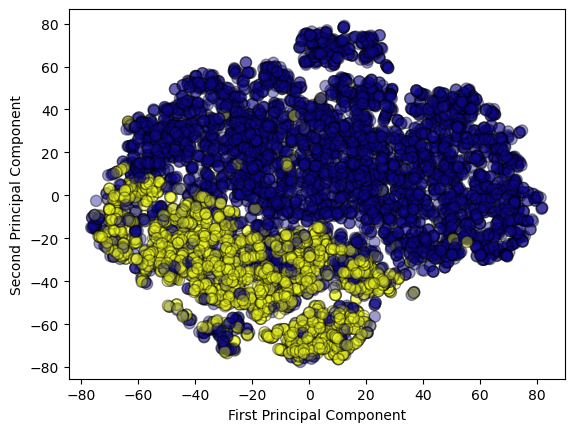

In [57]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [58]:
from sklearn import manifold
from time import time

Time code evaluation for perplexity=1 in 3.4 sec
Time code evaluation for perplexity=5 in 3.7 sec
Time code evaluation for perplexity=10 in 3.7 sec
Time code evaluation for perplexity=15 in 4.1 sec
Time code evaluation for perplexity=20 in 4.6 sec
Time code evaluation for perplexity=30 in 5.1 sec
Time code evaluation for perplexity=40 in 6.4 sec
Time code evaluation for perplexity=50 in 6.9 sec
Time code evaluation for perplexity=100 in 9.5 sec


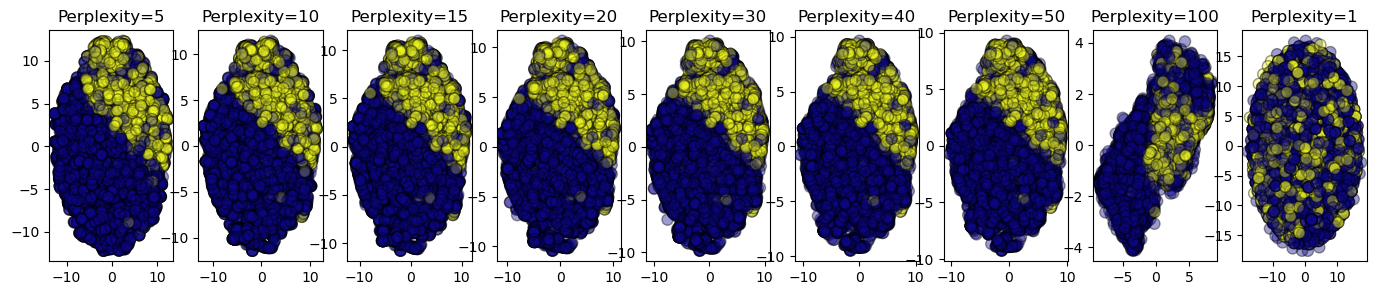

In [59]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=300,
        )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1],
               c=full_df_filtered['Healthy_Status'],
               cmap='plasma',
               alpha=0.4,
               edgecolors='black',
               s=65
               );
    ax.axis("tight")

Методы PCA и TSNE демонстрируют разделение классов, визуализация показывает, что на начальных значениях perplexity результаты примерно одинаковы.

### Задание 8

In [62]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [63]:
table_data.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status'],
      dtype='object')

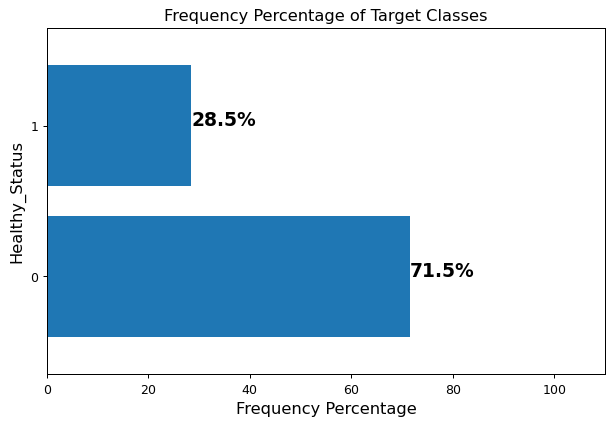

In [64]:
clf_index = 9
plt.figure(figsize=(35,20), dpi=90)
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

Виден дисбаланс классов, избавимся от него с помощью метода SMOTE

In [66]:
from imblearn.over_sampling import SMOTE

In [67]:
target_column = 'Healthy_Status'

smote = SMOTE(random_state=0)
X_initial = table_data.drop(target_column, axis=1)
y_initial = table_data[target_column]

X, y = smote.fit_resample(X_initial, y_initial)

df = pd.DataFrame(X, columns=X_initial.columns)
df[target_column] = y

df[target_column].value_counts()

Healthy_Status
0    5039
1    5039
Name: count, dtype: int64

In [68]:
X = df.drop(df.columns[[clf_index]], axis=1).iloc[:,:]
y = pd.Series(LabelEncoder().fit_transform(df.iloc[:, clf_index]))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=0, stratify=y.values)

Возьмем за базовую отметку результаты модели наивного гауссовского байесовского алгоритма

In [71]:
сlassifier = GaussianNB()
сlassifier.fit(X_train, y_train)

GaussianNB()

In [72]:
y_train__pred = сlassifier.predict(X_train)
y_test__pred = сlassifier.predict(X_test)

In [73]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__pred)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__pred)}'
)

('Accuracy train data 0.8887156223419337',
 'Accuracy test data 0.8938492063492064')

In [74]:
(
    f'F1 score train data {f1_score(y_train, y_train__pred)}',
    f'F1 score test data {f1_score(y_test, y_test__pred)}'
)

('F1 score train data 0.8961502844291573',
 'F1 score test data 0.9004651162790698')

              precision    recall  f1-score   support

        True       0.95      0.83      0.89      1512
       False       0.85      0.96      0.90      1512

    accuracy                           0.89      3024
   macro avg       0.90      0.89      0.89      3024
weighted avg       0.90      0.89      0.89      3024



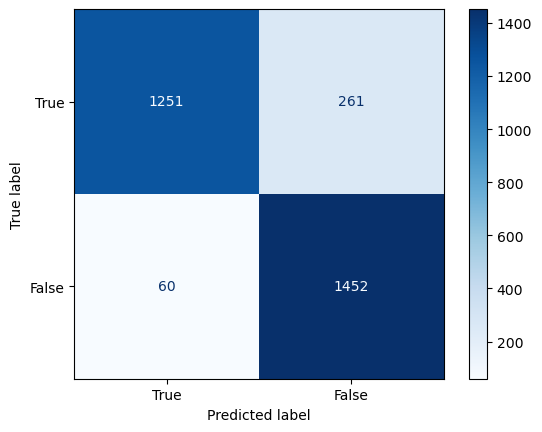

In [75]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__pred, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__pred, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# LAMA

In [129]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [131]:
autoML_df = df

In [138]:
train_data, test_data = train_test_split(autoML_df, test_size=0.2, stratify=autoML_df['Healthy_Status'], random_state=42)

In [143]:
automl = TabularAutoML(
    task=Task('binary'),
    timeout=100,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42},
)

In [144]:
predictions = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'}, verbose=0)

In [145]:
test_predictions = automl.predict(test_data).data

In [146]:
for i in range(len(test_predictions)):
    if test_predictions[i] > 0.5:
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0

In [147]:
predictions_data = predictions.data
for i in range(len(predictions_data)):
    if predictions_data[i] > 0.5:
        predictions_data[i] = 1
    else:
        predictions_data[i] = 0

In [148]:
(
    f'Accuracy train data {accuracy_score(train_data["Healthy_Status"], predictions_data)}',
    f'Accuracy test data {accuracy_score(test_data["Healthy_Status"], test_predictions)}'
)

('Accuracy train data 0.9844951624906971',
 'Accuracy test data 0.9861111111111112')

In [149]:
(
    f'F1 score train data {f1_score(train_data["Healthy_Status"], predictions_data)}',
    f'F1 score test data {f1_score(test_data["Healthy_Status"], test_predictions)}'
)

('F1 score train data 0.9845009299442034',
 'F1 score test data 0.9860418743768694')

              precision    recall  f1-score   support

        True       0.98      0.99      0.99      1008
       False       0.99      0.98      0.99      1008

    accuracy                           0.99      2016
   macro avg       0.99      0.99      0.99      2016
weighted avg       0.99      0.99      0.99      2016



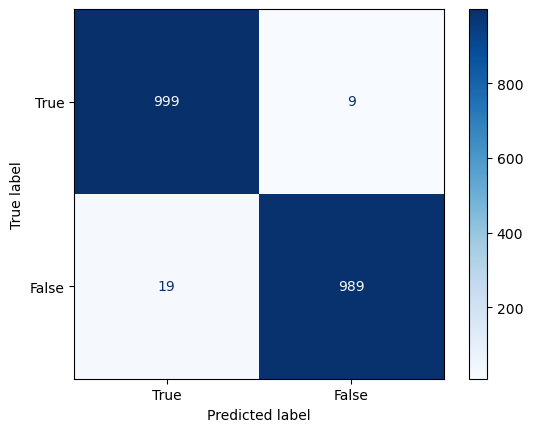

In [150]:
target_names = ['True', 'False']
labels_names = [0, 1]
print(classification_report(test_data['Healthy_Status'], test_predictions, labels=labels_names, target_names=target_names))

cm = confusion_matrix(test_data['Healthy_Status'], test_predictions, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [151]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


In [152]:
algo = automl.levels[0][0].ml_algos[0]
model = algo.models[0]
print(f'Алгоритм - {type(algo).__name__}\nМодель - {type(model).__name__}\n')

Алгоритм - BoostLGBM
Модель - Booster



In [153]:
with open(f'./lightautoml_electrocardiogram_m2_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [154]:
import subprocess
from threading import Thread

def start_mlflow():
    subprocess.run(["mlflow", "ui", "--host", "0.0.0.0", "--port", "5000"])

Thread(target=start_mlflow, daemon=True).start()

In [155]:
mlflow.set_tracking_uri(uri='http://localhost:5000')
mlflow.set_experiment('Task 2')

<Experiment: artifact_location='mlflow-artifacts:/815572667296263577', creation_time=1744220956347, experiment_id='815572667296263577', last_update_time=1744220956347, lifecycle_stage='active', name='Task 2', tags={}>

In [156]:
with mlflow.start_run(run_name='LAMA'):
    mlflow.log_params(
        {
            'n_jobs': 4, 
            'cv': 3, 
            'random_state': 42,
            'timeout': 100,
            'cpu_limit': 4,
            'algoritm': algo,
            'model': model
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(train_data['Healthy_Status'], predictions_data),
            'Accuracy test data': accuracy_score(test_data["Healthy_Status"], test_predictions),
            'F1 score train data': f1_score(train_data["Healthy_Status"], predictions_data),
            'F1 score test data': f1_score(test_data["Healthy_Status"], test_predictions),
        }
    )
    mlflow.log_artifact('./lightautoml_electrocardiogram_m2_model.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lama_model',
        signature=infer_signature(train_data, predictions_data),
        input_example=train_data,
    )

🏃 View run LAMA at: http://localhost:5000/#/experiments/815572667296263577/runs/dbcfb1e90b3144bb868b722c5866ae5d
🧪 View experiment at: http://localhost:5000/#/experiments/815572667296263577


# FEDOT

In [143]:
from fedot.api.main import Fedot

In [145]:
fedot_model = Fedot(problem='classification', timeout=3)

In [147]:
obtained_pipeline = fedot_model.fit(features=X_train, target=y_train)

2025-04-18 23:22:04,118 - ApiComposer - Initial pipeline was fitted in 2.7 sec.
2025-04-18 23:22:04,119 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 13.4 sec.
2025-04-18 23:22:04,120 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2025-04-18 23:22:04,133 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-04-18 23:22:04,275 - ApiComposer - Pipeline composition started.


Generations:   0%|                                                                          | 0/10000 [00:00<?, ?gen/s]

2025-04-18 23:22:11,223 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-04-18 23:22:20,479 - MultiprocessingDispatcher - 18 individuals out of 21 in previous population were evaluated successfully.
2025-04-18 23:22:25,155 - MultiprocessingDispatcher - 9 individuals out of 10 in previous population were evaluated successfully.
2025-04-18 23:22:26,579 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|                                                               | 1/10000 [00:22<61:37:40, 22.19s/gen]

2025-04-18 23:22:32,142 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2025-04-18 23:22:37,730 - MultiprocessingDispatcher - 7 individuals out of 7 in previous population were evaluated successfully.
2025-04-18 23:22:38,888 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                               | 2/10000 [00:34<45:29:04, 16.38s/gen]

2025-04-18 23:22:42,800 - MultiprocessingDispatcher - 16 individuals out of 18 in previous population were evaluated successfully.
2025-04-18 23:22:44,980 - MultiprocessingDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.


Generations:   0%|                                                               | 3/10000 [00:40<32:26:18, 11.68s/gen]

2025-04-18 23:22:53,344 - MultiprocessingDispatcher - 29 individuals out of 31 in previous population were evaluated successfully.
2025-04-18 23:23:00,680 - MultiprocessingDispatcher - 27 individuals out of 27 in previous population were evaluated successfully.
2025-04-18 23:23:00,698 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.


Generations:   0%|                                                               | 4/10000 [00:56<36:51:23, 13.27s/gen]

2025-04-18 23:23:06,176 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2025-04-18 23:23:06,695 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|                                                               | 5/10000 [01:02<29:34:04, 10.65s/gen]

2025-04-18 23:23:12,240 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


Generations:   0%|                                                               | 6/10000 [01:07<24:44:53,  8.91s/gen]

2025-04-18 23:23:17,552 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2025-04-18 23:23:18,020 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


Generations:   0%|                                                               | 7/10000 [01:13<21:54:03,  7.89s/gen]

2025-04-18 23:23:19,630 - MultiprocessingDispatcher - 11 individuals out of 12 in previous population were evaluated successfully.


Generations:   0%|                                                               | 8/10000 [01:15<16:21:02,  5.89s/gen]

2025-04-18 23:23:21,960 - MultiprocessingDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2025-04-18 23:23:23,458 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-18 23:23:23,463 - MultiprocessingDispatcher - 7 individuals out of 7 in previous population were evaluated successfully.


Generations:   0%|                                                               | 9/10000 [01:19<14:33:39,  5.25s/gen]

2025-04-18 23:23:25,428 - MultiprocessingDispatcher - 4 individuals out of 5 in previous population were evaluated successfully.
2025-04-18 23:23:29,260 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                              | 10/10000 [01:24<15:01:54,  5.42s/gen]

2025-04-18 23:23:34,167 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-18 23:23:35,631 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                              | 11/10000 [01:31<15:50:24,  5.71s/gen]

2025-04-18 23:23:36,764 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-18 23:23:37,252 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2025-04-18 23:23:38,373 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|                                                              | 12/10000 [01:33<13:20:06,  4.81s/gen]

2025-04-18 23:23:39,145 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-04-18 23:23:40,456 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                              | 13/10000 [01:36<11:02:37,  3.98s/gen]

2025-04-18 23:23:41,028 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2025-04-18 23:23:41,690 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-18 23:23:43,085 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-04-18 23:23:43,660 - MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|                                                              | 14/10000 [01:39<10:23:27,  3.75s/gen]

2025-04-18 23:23:44,275 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2025-04-18 23:23:44,815 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-04-18 23:23:46,554 - MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|                                                               | 15/10000 [01:42<9:40:46,  3.49s/gen]

2025-04-18 23:23:46,575 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                              | 15/10000 [01:42<18:53:39,  6.81s/gen]

2025-04-18 23:23:46,705 - ApiComposer - Hyperparameters tuning started with 1 min. timeout


2025-04-18 23:23:49,620 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [lgbm]}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.5931892355539934, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 36, 'n_jobs': 1, 'verbose': -1, 'class_weight': 'balanced', 'num_leaves': 132, 'min_data_in_leaf': 45, 'learning_rate': 0.06538538463180736, 'force_col_wise': True, 'force_row_wise ': False, 'colsample_bytree': 0.9366198710288591, 'subsample': 0.4381899631393325, 'reg_alpha': 0.11351929677839756, 'reg_lambda': 0.001519792663211914} 
Initial metric: [0.996]
  0%|                                        | 24/100000 [01:12<83:55:17,  3.02s/trial, best loss: -0.9972466765462243]
2025-04-18 23:25:05,696 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [lgbm]}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.017252185560672102, 'extra_trees': False, 'enable_catego

In [149]:
y_train__predict = fedot_model.predict(X_train)
y_test__predict = fedot_model.predict(X_test)

In [151]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data 0.9975900198468953',
 'Accuracy test data 0.9831349206349206')

In [153]:
(
    f'F1 score train data {f1_score(y_train, y_train__predict)}',
    f'F1 score test data {f1_score(y_test, y_test__predict)}'
)

('F1 score train data 0.9975930907546369',
 'F1 score test data 0.9831404958677686')

              precision    recall  f1-score   support

        True       0.98      0.98      0.98      1512
       False       0.98      0.98      0.98      1512

    accuracy                           0.98      3024
   macro avg       0.98      0.98      0.98      3024
weighted avg       0.98      0.98      0.98      3024



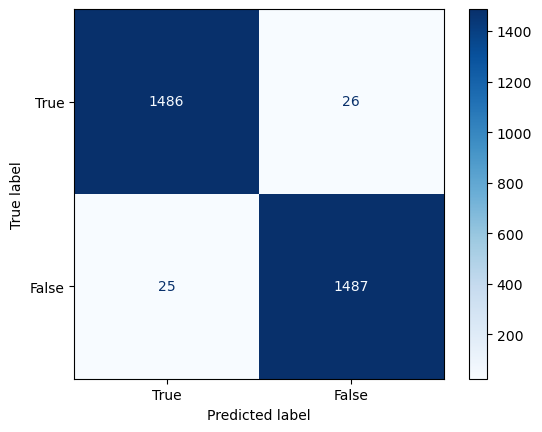

In [155]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__predict, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__predict, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [157]:
fedot_model.current_pipeline

{'depth': 1, 'length': 1, 'nodes': [lgbm]}

In [159]:
with open(f'./fedot_model_task2.pkl', 'wb') as f:
    pickle.dump(fedot_model, f)

In [161]:
with mlflow.start_run(run_name='FEDOT'):
    mlflow.log_params(
        {
            'problem':'classification',
            'timeout': 3,
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict),
            'F1 score train data': f1_score(y_train, y_train__predict),
            'F1 score test data': f1_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./fedot_model_task2.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=fedot_model,
        artifact_path='model_fedot',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train,
    )

🏃 View run FEDOT at: http://localhost:5000/#/experiments/815572667296263577/runs/96caa2c309e242e49227bc6297616e8b
🧪 View experiment at: http://localhost:5000/#/experiments/815572667296263577


# H2O

In [166]:
import h2o
from h2o.automl import H2OAutoML
import mlflow
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, 
                           classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay)
import pickle

In [168]:
# Инициализация H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 21.0.5+-13047016-b750.29, mixed mode)
  Starting server from C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\dvm10\AppData\Local\Temp\tmpdtd9xzyz
  JVM stdout: C:\Users\dvm10\AppData\Local\Temp\tmpdtd9xzyz\h2o_dvm10_started_from_python.out
  JVM stderr: C:\Users\dvm10\AppData\Local\Temp\tmpdtd9xzyz\h2o_dvm10_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 16 days
H2O_cluster_name:,H2O_from_python_dvm10_bhya3w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.932 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [169]:
# Подготовка данных
hf = h2o.H2OFrame(df)
hf['Healthy_Status'] = hf['Healthy_Status'].asfactor()  # Для классификации

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [170]:
# Разделение данных
train, test = hf.split_frame(ratios=[0.7], seed=200)
x = hf.columns
x.remove('Healthy_Status')
y = 'Healthy_Status'

In [171]:
# Обучение модели (эквивалент 5 минут в TPOT)
aml = H2OAutoML(
    max_runtime_secs=300,  # 5 минут
    seed=42,
    verbosity='info',
    exclude_algos=["DeepLearning", "StackedEnsemble"]  # Для простоты
)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
23:26:07.245: Project: AutoML_1_20250418_232607
23:26:07.246: 5-fold cross-validation will be used.
23:26:07.246: Setting stopping tolerance adaptively based on the training frame: 0.01188792585913685
23:26:07.247: Build control seed: 42
23:26:07.247: training frame: Frame key: AutoML_1_20250418_232607_training_py_3_sid_b75e    cols: 10    rows: 7076  chunks: 1    size: 164867  checksum: -6255081628320331078
23:26:07.247: validation frame: NULL
23:26:07.247: leaderboard frame: NULL
23:26:07.247: blending frame: NULL
23:26:07.247: response column: Healthy_Status
23:26:07.247: fold column: null
23:26:07.247: weights column: null
23:26:07.253: AutoML: XGBoost is not available; skipping it.
23:26:07.255: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20250418_232607_model_91


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    158                158                         308474                 10           10           10            86            253           150.848

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 9.14245696250906e-05
RMSE: 0.00956161961307239
LogLoss: 0.003822064434820299
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8802412802337098
       0     1     Error    Rate
-----  ----  ----  -------  ------------
0      3539  0     0        (0.0/3539.0)
1      0     3537  0        (0.0/3537.0)
Total  3539  3537  0        (0.0/7076.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.880241     1         193
max f2                       0.880241     1         193
max f0point5                 0.880241     1         193
max accuracy                 0.880241     1         193
max precision                0.999834     1         0
max recall                   0.880241     1         193
max specificity              0.999834     1         0
max absolute_mcc             0.880241     1         193
max min_per_class_accuracy   0.880241     1         193
max mean_per_class_accuracy  0.880241     1         193
max tns                      0.999834     3539      0
max fns                      0.999834     3519      0
max fps                      9.87436e-06  3539      399
max tps                      0.880241     3537      193
max tnr                      0.999834     1         0
max fnr                      0.999834     0.994911  0
max fpr                      9.87436e-06  1         399
max tpr                      0.880241     1         193

Gains/Lift Table: Avg response rate: 49,99 %, avg score: 49,99 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0100339                   0.999681           2.00057  2.00057            1                0.999748     1                           0.999748            0.0200735       0.0200735                  100.057  100.057            0.0200735
2        0.0200678                   0.999612           2.00057  2.00057            1                0.999648     1                           0.999698            0.0200735       0.040147                   100.057  100.057            0.040147
3        0.0301018                   0.999554           2.00057  2.00057            1                0.999585     1                           0.99966             0.0200735       0.0602205                  100.057  100.057            0.0602205
4        0.0401357                   0.999492           2.00057  2.00057            1                0.999519     1                           0.999625            0.0200735       0.080294                   100.057  100.057            0.080294
5        0.0500283                   0.99945            2.00057  2.00057            1                0.999471     1                           0.999594            0.0197908       0.100085            

In [172]:
# Получение лучшей модели
best_model = aml.leader

In [173]:
# Предсказания
train_pred = best_model.predict(train)['predict'].as_data_frame().values.ravel()
test_pred = best_model.predict(test)['predict'].as_data_frame().values.ravel()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [174]:
# Метрики
y_train_true = train['Healthy_Status'].as_data_frame().values.ravel()
y_test_true = test['Healthy_Status'].as_data_frame().values.ravel()

C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [175]:
(
    f'Accuracy train data {accuracy_score(y_train_true, train_pred)}',
    f'Accuracy test data {accuracy_score(y_test_true, test_pred)}'
)

('Accuracy train data 0.9998586772187676',
 'Accuracy test data 0.9786808794137242')

In [176]:
(
    f'F1 score train data {f1_score(y_train_true, train_pred)}',
    f'F1 score test data {f1_score(y_test_true, test_pred)}'
)

('F1 score train data 0.9998586172769688',
 'F1 score test data 0.9784366576819407')

In [177]:
# Classification report
target_names = ['True', 'False']
labels_names = [0, 1]
print(classification_report(y_test_true, test_pred, 
                          labels=labels_names, 
                          target_names=target_names))

              precision    recall  f1-score   support

        True       0.97      0.99      0.98      1500
       False       0.99      0.97      0.98      1502

    accuracy                           0.98      3002
   macro avg       0.98      0.98      0.98      3002
weighted avg       0.98      0.98      0.98      3002



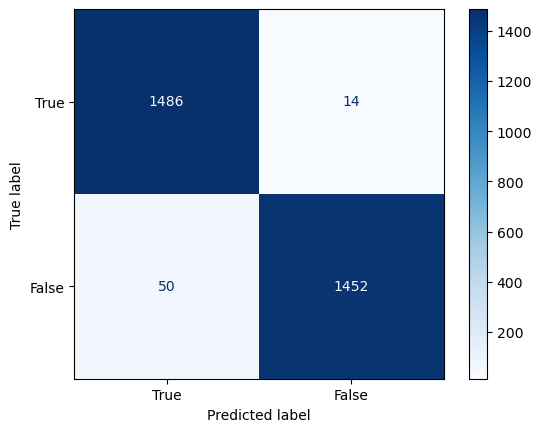

In [178]:
# Confusion matrix
cm = confusion_matrix(y_test_true, test_pred, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [179]:
# Сохранение модели
model_path = h2o.save_model(best_model, path="./", force=True)

In [180]:
# Логирование в MLflow
with mlflow.start_run(run_name='H2O_AutoML'):
    # Параметры
    mlflow.log_params({
        'max_runtime_secs': 300,
        'seed': 42,
        'algorithm': best_model.algo
    })
    
    # Метрики
    mlflow.log_metrics({
        'Accuracy_train': accuracy_score(y_train_true, train_pred),
        'Accuracy_test': accuracy_score(y_test_true, test_pred),
        'F1_train': f1_score(y_train_true, train_pred),
        'F1_test': f1_score(y_test_true, test_pred)
    })
    
    # Артефакты
    mlflow.log_artifact(model_path)
    
    # Логирование модели H2O
    mlflow.h2o.log_model(
        h2o_model=best_model,
        artifact_path='h2o_model',
        registered_model_name='H2O_AutoML_Model'
    )

2025/04/18 23:31:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'H2O_AutoML_Model'.
2025/04/18 23:31:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: H2O_AutoML_Model, version 1


🏃 View run H2O_AutoML at: http://localhost:5000/#/experiments/815572667296263577/runs/d770281544e2431e9741cbac6383c794
🧪 View experiment at: http://localhost:5000/#/experiments/815572667296263577


Created version '1' of model 'H2O_AutoML_Model'.


In [181]:
# Завершение работы H2O
h2o.cluster().shutdown()

H2O session _sid_b75e closed.
